In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import gc

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set working directory
%cd /content/gdrive/My Drive/CV_Project

/content/gdrive/My Drive/CV_Project


In [ ]:
!pip install git+https://github.com/ncullen93/torchsample

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-rcdigybj
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-rcdigybj
  Created wheel for torchsample: filename=torchsample-0.1.3-py3-none-any.whl size=43432 sha256=4c2940fc67ed3ac5ba7de9fbb79450e63871a0e0e4eafef8a98c3cdd6bc77337
  Stored in directory: /tmp/pip-ephem-wheel-cache-kwsezxew/wheels/88/d1/14/b6fc8c104020db989a0941e99c350d5db17bdd9366245c8c2e
Successfully built torchsample
  Attempting uninstall: torchsample
    Found existing installation: torchsample 0.1.3
    Uninstalling torchsample-0.1.3:
      Successfully uninstalled torchsample-0.1.3


## Loading and Preprocessing data


In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False): 
    set_random_seed(0)   
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    
    # Data Augmentation 
    if augment: 
        pass
        data += [np.flip(img,1) for img in data]
        labels += labels
 

    # Data Normalization
    if zero_centered:
        pass
        data -= np.mean(data, 0)

         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Mountain', 1: 'TallBuilding', 2: 'OpenCountry', 3: 'LivingRoom', 4: 'Industrial', 5: 'Street', 6: 'Kitchen', 7: 'Store', 8: 'InsideCity', 9: 'Suburb', 10: 'Bedroom', 11: 'Flower', 12: 'Coast', 13: 'Office', 14: 'Highway', 15: 'Forest'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 32 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 12 mini

Forest


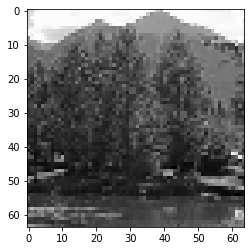

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

Training a Network From Scratch


First, let's define a simpe network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
  

Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  

Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:09 | Train Loss: 2.7568 | Average Loss: 2.7568 
Epoch: 1 | Iter:   20 | Time: 00:00:09 | Train Loss: 2.2201 | Average Loss: 2.6270 
Accuracy: 0.369792 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:09 | Train Loss: 1.7504 | Average Loss: 2.4415 
Epoch: 2 | Iter:   20 | Time: 00:00:09 | Train Loss: 1.6060 | Average Loss: 2.2417 
Accuracy: 0.424479 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:09 | Train Loss: 1.3842 | Average Loss: 2.1154 
Epoch: 3 | Iter:   20 | Time: 00:00:09 | Train Loss: 1.2620 | Average Loss: 1.9864 
Accuracy: 0.450521 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:09 | Train Loss: 1.0796 | Average Loss: 1.8854 
Epoch: 4 | Iter:   20 | Time: 00:00:10 | Train Loss: 1.0240 | Average Loss: 1.7849 
Accuracy: 0.468750 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:10 | Train Loss: 0.8425 | Average Loss: 1.7001 
Epoch: 5 | Iter:   20 | Time: 00:00:10 | Train Loss: 0.8346 | Average Loss: 1.6161 
Accuracy: 0.4791

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 32 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 150 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 12 min

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class Improved_TNet(nn.Module):
  def __init__(self):
    super(Improved_TNet,self).__init__()
    self.features = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Conv2d(32, 256, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5)
    )
    self.classifier = nn.Sequential(
        nn.Linear(2304, 16),
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x
   

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = Improved_TNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8126 | Average Loss: 2.8126 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5247 | Average Loss: 2.7008 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3219 | Average Loss: 2.5594 
Epoch: 1 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.0123 | Average Loss: 2.4304 
Accuracy: 0.380208 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.1373 | Average Loss: 2.3638 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.8962 | Average Loss: 2.2686 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.8060 | Average Loss: 2.1717 
Epoch: 2 | Iter:   60 | Time: 00:00:02 | Train Loss: 1.5232 | Average Loss: 2.1030 
Accuracy: 0.476562 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 1.6864 | Average Loss: 2.0582 
Epoch: 3 | Iter:   20 | Time: 00:00:02 | Train Loss: 1.5542 | Average Loss: 2.0010 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.5692 | Average Loss: 1.9439 
Epoc

Tried **three different techniques** to increase the accuracy of my model. 

### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 32

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 150 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 12 min

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class ModelArchitectureModification(nn.Module):
  def __init__(self):
    super(ModelArchitectureModification,self).__init__()
    self.features = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5),
        nn.Conv2d(64, 400, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5)
    )

    self.classifier = nn.Sequential(
        nn.Linear(3600, 16),
    )
    
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x
   

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = ModelArchitectureModification()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8477 | Average Loss: 2.8477 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5501 | Average Loss: 2.8028 
Epoch: 1 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.4442 | Average Loss: 2.6408 
Epoch: 1 | Iter:   60 | Time: 00:00:02 | Train Loss: 2.1771 | Average Loss: 2.5380 
Accuracy: 0.286458 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:02 | Train Loss: 2.3020 | Average Loss: 2.4819 
Epoch: 2 | Iter:   20 | Time: 00:00:03 | Train Loss: 1.9120 | Average Loss: 2.4111 
Epoch: 2 | Iter:   40 | Time: 00:00:03 | Train Loss: 1.9274 | Average Loss: 2.3225 
Epoch: 2 | Iter:   60 | Time: 00:00:04 | Train Loss: 1.7224 | Average Loss: 2.2585 
Accuracy: 0.445312 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:05 | Train Loss: 1.8909 | Average Loss: 2.2177 
Epoch: 3 | Iter:   20 | Time: 00:00:05 | Train Loss: 1.7082 | Average Loss: 2.1599 
Epoch: 3 | Iter:   40 | Time: 00:00:06 | Train Loss: 1.7456 | Average Loss: 2.1017 
Epoc

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
img_size = (64, 64)
batch_size = 32

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 150 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 12 min

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class BatchNormalization(nn.Module):
  def __init__(self):
    super(BatchNormalization,self).__init__()
    self.features = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5),
        nn.Conv2d(32, 256, 3),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
        nn.Dropout(0.5)
    )

    self.classifier = nn.Sequential(
        nn.Linear(2304, 16),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = BatchNormalization()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.5393 | Average Loss: 3.5393 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6974 | Average Loss: 4.3868 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.8273 | Average Loss: 3.6317 
Epoch: 1 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.2673 | Average Loss: 3.2826 
Accuracy: 0.325521 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.5276 | Average Loss: 3.1100 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.0352 | Average Loss: 2.9312 
Epoch: 2 | Iter:   40 | Time: 00:00:02 | Train Loss: 2.1227 | Average Loss: 2.7855 
Epoch: 2 | Iter:   60 | Time: 00:00:02 | Train Loss: 1.7911 | Average Loss: 2.6948 
Accuracy: 0.414062 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 1.9217 | Average Loss: 2.6222 
Epoch: 3 | Iter:   20 | Time: 00:00:03 | Train Loss: 1.8461 | Average Loss: 2.5256 
Epoch: 3 | Iter:   40 | Time: 00:00:03 | Train Loss: 2.0004 | Average Loss: 2.4458 
Epoc

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

import torchvision.transforms as transforms
import torchsample as ts

train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0], [1])
    ])

test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0], [1])
    ])
# Train data augmented
augmentedTrainData = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./data/train/', transform=train),
batch_size=64, shuffle=True)

# Test data augmented
augmentedTestData = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('./data/test/', transform=test),
batch_size=64, shuffle=True)


In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class AugmentationTechnique(nn.Module):
  def __init__(self):
    super(AugmentationTechnique,self).__init__()
    self.features = torch.nn.Sequential(
      nn.Conv2d(1, 32, 3),
      nn.ReLU(),
      nn.MaxPool2d(4, stride=4),
      nn.Dropout(0.5),
      nn.Conv2d(32, 256, 3),
      nn.ReLU(),
      nn.MaxPool2d(4, stride=4),
      nn.Dropout(0.5)
    )

    self.classifier = nn.Sequential(
      nn.Linear(2304, 16),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x



In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = AugmentationTechnique()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 100
train_option['device'] = 'gpu'
trainModel(net, augmentedTrainData, train_option, augmentedTestData)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8605 | Average Loss: 2.8605 
Epoch: 1 | Iter:   20 | Time: 00:00:05 | Train Loss: 2.7623 | Average Loss: 2.8060 
Accuracy: 0.140000 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:11 | Train Loss: 2.6115 | Average Loss: 2.7626 
Epoch: 2 | Iter:   20 | Time: 00:00:16 | Train Loss: 2.4780 | Average Loss: 2.6980 
Accuracy: 0.272500 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:00:21 | Train Loss: 2.2424 | Average Loss: 2.6427 
Epoch: 3 | Iter:   20 | Time: 00:00:26 | Train Loss: 2.2665 | Average Loss: 2.5890 
Accuracy: 0.265000 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:00:32 | Train Loss: 1.9537 | Average Loss: 2.5354 
Epoch: 4 | Iter:   20 | Time: 00:00:36 | Train Loss: 2.0844 | Average Loss: 2.4869 
Accuracy: 0.317500 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:00:42 | Train Loss: 2.0252 | Average Loss: 2.4520 
Epoch: 5 | Iter:   20 | Time: 00:00:47 | Train Loss: 2.1618 | Average Loss: 2.4097 
Accuracy: 0.3600

Fine Tuning a Pre-Trained Deep Network


In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 100 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 12 min

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
finetune_alexnet = models.alexnet(pretrained=True)
finetune_alexnet.classifier[6] = nn.Linear(4096,16)

train_option = {}
train_option['lr'] = 0.00015
train_option['epoch'] = 15
train_option['device'] = 'gpu'
trainModel(finetune_alexnet, trainloader_large, train_option, testloader_large)
gc.collect()


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7856 | Average Loss: 2.7856 
Epoch: 1 | Iter:   20 | Time: 00:00:06 | Train Loss: 0.9991 | Average Loss: 1.4080 
Epoch: 1 | Iter:   40 | Time: 00:00:11 | Train Loss: 0.4687 | Average Loss: 1.0368 
Accuracy: 0.781250 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:14 | Train Loss: 0.4090 | Average Loss: 0.9404 
Epoch: 2 | Iter:   20 | Time: 00:00:20 | Train Loss: 0.4477 | Average Loss: 0.8102 
Epoch: 2 | Iter:   40 | Time: 00:00:26 | Train Loss: 0.4870 | Average Loss: 0.7185 
Accuracy: 0.789062 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:29 | Train Loss: 0.2621 | Average Loss: 0.6790 
Epoch: 3 | Iter:   20 | Time: 00:00:35 | Train Loss: 0.3824 | Average Loss: 0.6085 
Epoch: 3 | Iter:   40 | Time: 00:00:40 | Train Loss: 0.1313 | Average Loss: 0.5524 
Accuracy: 0.802083 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:43 | Train Loss: 0.0790 | Average Loss: 0.5298 
Epoch: 4 | Iter:   20 | Time: 00:00:49 | Train Loss:

702

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
def getFeatures(model, features_count, dataset):

  if torch.cuda.is_available():
    model = model.cuda()
        
  features = []
  labels = []
    
  for img, label in dataset:
    if torch.cuda.is_available():
      img  = img.float().cuda()
      label = label.long().cuda()
        
    img_out = model(img)
    
    for index2, img_it in enumerate(img_out):
      features.append(np.array(img_it[:features_count].cpu().detach().numpy()))
      labels.append(label[index2].cpu().detach().numpy())
            
  return np.array(features), np.array(labels)
    

train_feat, train_label = getFeatures(finetune_alexnet, 400, trainloader_large)
test_feat, test_label = getFeatures(finetune_alexnet, 400, testloader_large)


In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn import svm
from sklearn import preprocessing

#Calculating accuracy using techniques used in assignment 3

def train_SVM(X, Y):
  return svm.SVC(C=0.95).fit(X, Y)

def predict_SVM(clf, X):
  return clf.predict(X)


clf = train_SVM(train_feat, train_label)
test_label_pred = predict_SVM(clf, test_feat)

accuracy = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
print("The accuracy is {:.2f}%".format(accuracy*100))


The accuracy is 82.81%


In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
#Fine Tune resnet 50
import torch.optim as optim
import time
resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(2048, 16)

train_option = {'optimizer':optim.RMSprop(resnet_model.parameters(), lr=0.0001)}
train_option['lr'] = 0.0001
train_option['epoch'] = 10
train_option['device'] = 'gpu'
trainModel(resnet_model, trainloader_large, train_option, testloader_large)


Epoch: 1 | Iter:    0 | Time: 00:00:11 | Train Loss: 2.8156 | Average Loss: 2.8156 
Epoch: 1 | Iter:   20 | Time: 00:00:28 | Train Loss: 0.9621 | Average Loss: 1.3177 
Epoch: 1 | Iter:   40 | Time: 00:00:45 | Train Loss: 0.5792 | Average Loss: 0.9688 
Epoch: 1 | Iter:   60 | Time: 00:01:03 | Train Loss: 0.3483 | Average Loss: 0.8134 
Epoch: 1 | Iter:   80 | Time: 00:01:21 | Train Loss: 0.2174 | Average Loss: 0.7084 
Accuracy: 0.838542 | Time: 00:00:02
Epoch: 2 | Iter:    0 | Time: 00:01:41 | Train Loss: 0.2519 | Average Loss: 0.6327 
Epoch: 2 | Iter:   20 | Time: 00:01:59 | Train Loss: 0.1438 | Average Loss: 0.5548 
Epoch: 2 | Iter:   40 | Time: 00:02:17 | Train Loss: 0.1669 | Average Loss: 0.4901 
Epoch: 2 | Iter:   60 | Time: 00:02:34 | Train Loss: 0.0772 | Average Loss: 0.4412 
Epoch: 2 | Iter:   80 | Time: 00:02:52 | Train Loss: 0.0123 | Average Loss: 0.4007 
Accuracy: 0.898438 | Time: 00:00:02
Epoch: 3 | Iter:    0 | Time: 00:03:13 | Train Loss: 0.0277 | Average Loss: 0.3650 
Epoc

<!--Write your report here in markdown or html-->
